#  Convolutional NN it for facial keypoints recognition

Here I will build a convolutional neural network, and train it for the task of facial keypoints recognition. The data are obtained from Kaggle: **LINK**, and consists of **info**.

I will build the CNN using tensorflow **link**. 

##  Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib inline

##  Loading data

In [2]:
# Reading source data.
training_data = pd.read_csv('training.csv')

In [3]:
#Images are stored as string. We convert them to a np array. 

images = training_data['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))
images = np.vstack([images.iloc[i] for i in range(len(images))])

In [4]:
#Creating keypoints dataframe. 
keypoints = training_data.drop('Image', axis = 1)

## Data augmentation: Including reflected pictures into the dataset

In order to increase our dataset I will reflect all images left to right, and add them as different images.

This implies flipping the images, and reflecting all x-coordinates of the keypoints such that $x_{reflected} = 95 - x_{old}$.


In [5]:
# building an array of reflected images.
flipped_ims = np.zeros(images.shape)
for j in range(images.shape[0]):
    for i in range(96):
        flipped_ims[j,i*96:(i+1)*96] = np.flip(images[j,i*96:(i+1)*96])

In [6]:
# adding the reflected images to our images array. 
# RUN THIS CELL ONLY ONCE. 
images = np.vstack((images, flipped_ims))

In [7]:
# Now the keypoints. I need to switch left and right features, 
# and reflect the x coordinates by x --> 95-x (95 is the last coordinate of the picture. )

reflected_keypoints = pd.DataFrame(columns = keypoints.columns)

# We look for the correspoding columns by switching 'left' <--> 'right'.
for colname in reflected_keypoints.columns:
    if 'left' in colname:
        reference_col = colname.replace('left', 'right')
    elif 'right' in colname:
        reference_col = colname.replace('right','left')
    else:
        reference_col = colname
        
    # Assigning values and reflecting x coordinates
    # reflected_keypoints[colname] = keypoints[reference_col].apply(lambda x: 95-x if colname[-1]=='x' else x)
    # the one-line version is fine but I think separating is more readable.
    
    reflected_keypoints[colname] = keypoints[reference_col]
    if colname[-1] == 'x':
        reflected_keypoints[colname] = reflected_keypoints[colname].apply(lambda x: 95-x)   

In [8]:
# Adding reflected keypoints to the original keypoints. 
# RUN THIS CELL ONLY ONCE.
keypoints = pd.concat([keypoints,reflected_keypoints], ignore_index=True)

## Perform a train_test_split in order to have a cross validation set. 

In [9]:
x_train, x_cv, keypoints_train, keypoints_cv = train_test_split(images, keypoints, 
                                                                test_size=500, random_state = 42)

In [10]:
# BASELINE
# As a guide, we compute the error on the cv set obtained by using the mean position of
# each keypoint.

mean_keypoints = keypoints_train.mean()
baseline_rmse = np.sqrt(((keypoints_cv - mean_keypoints)**2).mean().mean())

print('Using the mean poistion the RMSE on the cv set is: ', baseline_rmse)

Using the mean poistion the RMSE on the cv set is:  3.8490320110627083


A good estimation should improve on this result. 

##  Define a function for taking random batches. 

In [11]:
def next_batch(X, labels, batch_size):
    """ A function for generating training batches. 
    X = Collection of examples.
    labels = True labels. 
    batch_size = Number of elements to be randomly selected. """
    sample_indices = np.random.choice(range(len(X)), size = batch_size, 
                                      replace = False)
    
    images = X[sample_indices]
    keypoints = labels.iloc[sample_indices]
        
    return images, keypoints

# Building the CNN

I will start by using the same architechture I used in the course.For the moment I will use train_test_split to test my network a bit. Eventually this wont be necessary, as the dataset provides a separate test set. 

In [125]:
# Wrappers of tensorflow methods. This functions will help make
# the construction of the network more straightforward. 

def init_weights(shape):
    #init_random_dist = tf.initializers.random_normal(stddev=0.1)
    init_random_dist = tf.initializers.he_normal()
    return tf.get_variable('weights', shape=shape ,initializer= init_random_dist)

def init_bias(shape):
    #init_bias_vals = tf.random_uniform(shape=shape)
    init_bias_vals = tf.initializers.random_uniform()
    return tf.get_variable('bias', shape = shape ,initializer= init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

def output_act_function(input_layer):
    factor = tf.constant(96, dtype = tf.float32)
    return tf.multiply(factor, tf.nn.sigmoid(input_layer))

def sigmoid_layer(input_layer, size, max_val):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    factor = tf.constant(max_val, dtype = tf.float32)
    return tf.multiply(factor, tf.nn.sigmoid(tf.matmul(input_layer, W) + b))
    

def new_bn_layer(input_x, training, decay = 0.999):
    """ Wrapper function for tf.contrib.layers.batch_norm """
    
    return tf.contrib.layers.batch_norm(input_x, decay = decay, is_training = training  )

In [116]:
# A handmade implementation of batch_normalization. 
def init_gamma(shape):
    # I am not using the argument shape!
    init_gamma_val = tf.constant(1,shape =shape, dtype = tf.float32)
    return tf.get_variable('gamma', initializer = init_gamma_val)

def init_beta(shape):
    # I am not using the argument shape!
    init_beta_val = tf.constant(0, shape =shape, dtype = tf.float32)
    return tf.get_variable('beta', initializer = init_beta_val)

def bn_layer(input_x, is_training, bn_type = 'normal', decay = 0.999):
    
    """Implements batch normalization. 
    input_x: A Tensor. Is the data to normalize.
    is_training: Bool. Indicates whether we are in training o predictino phase. 
    bn_type: 'normal' or 'convo', indicates over which indeces we take the means. 
              if 'normal', we use only the first index (batch number).
              if 'conv', uses [0,1,2]
    decay: float. decay parameter for the running averages. 
    """
    
    if bn_type == 'normal':
        shape = input_x.shape[1:]
        axes = [0]
    elif bn_type == 'convo':
        shape = input_x.shape[-1]
        axes = [0,1,2]
        
    #running mean and variance to be sued for inference.
    pop_mean = tf.Variable(tf.zeros(shape), trainable=False) 
    pop_var = tf.Variable(tf.ones(shape), trainable=False)
    
    gamma = init_gamma(shape) #in the normalization I am using this is the number of channels. 
    beta = init_beta(shape)
    
    batch_mean, batch_var = tf.nn.moments(input_x, axes)  
    
    def train_phase():
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(input_x, batch_mean, batch_var,
                                                    offset = beta, scale = gamma,
                                                    variance_epsilon=0.0001)
    
    def infer_phase(): 
        return tf.nn.batch_normalization(input_x, pop_mean, pop_var, offset = beta, 
                                  scale = gamma, variance_epsilon=0.0001)
    
        
    return tf.cond(is_training, train_phase, infer_phase)
    

# Building the network

In [140]:
tf.reset_default_graph()

In [141]:
# PLACEHOLDERS

x = tf.placeholder(tf.float32, [None, 9216])
keypoints_true = tf.placeholder(tf.float32, [None, 30])
lr = tf.placeholder(tf.float32)
training = tf.placeholder(tf.bool)
#drop_rate = tf.placeholder(tf.float32)

In [142]:
x_images = tf.image.per_image_standardization(tf.reshape(x, [-1,96,96,1]))

In [143]:
# LAYERS

with tf.variable_scope('Convo1'):
    convo1 = convolutional_layer(x_images, [6,6,1,32]) # 6 x 6 filter, 1 channel in, 32 channels out. SAME padding.
                                            # so output images are also 96 x 96. 

    convo1_pool = tf.nn.max_pool(convo1, ksize=[1, 4, 4, 1],
                          strides=[1, 4, 4, 1], padding='SAME')   #output of 24 x 24 x 32
    convo1_pool_bn = new_bn_layer(convo1_pool, training)
    
with tf.variable_scope('Convo2'):    
    convo2 = convolutional_layer(convo1_pool, [2,2,32,64]) # 4x4 filter, 64 outputs. SAME padding.

    convo2_pool = max_pool_2by2(convo2) # 12 x 12 x64
    
    convo2_pool_bn = new_bn_layer(convo2_pool, training)
        
with tf.variable_scope('Convo3'):
    convo3 = convolutional_layer(convo2_pool_bn, [2,2,64,128]) # 2x2 filter, 128 outputs. SAME padding.

    convo3_pool = max_pool_2by2(convo3) # 6 x 6 x 128

    convo3_flat = tf.reshape(convo3_pool,[-1,6*6*128])
    
with tf.variable_scope('Full_one'):
    
    full_layer_one = tf.nn.relu(normal_full_layer(convo3_flat,1024))
    
    
# DROPOUT 

#full_one_dropout = tf.nn.dropout(full_layer_one, rate = drop_rate)

# OUTPUT LAYER
with tf.variable_scope('Output'):
    
    keypoints_pred = normal_full_layer(full_layer_one,30)
    

In [144]:
# LOSS FUNCTION
with tf.variable_scope('Loss'):
    masked_loss = tf.reduce_mean(tf.square(
        tf.boolean_mask(keypoints_pred - keypoints_true, tf.is_finite(keypoints_true) ) ) ) 
                                 
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
        
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)

        train = optimizer.minimize(masked_loss)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [145]:
# INITIALIZER

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [146]:
counter = 0

## Training

Currently on step 5000
Train MSE:  2.1492991 

CV MSE: 3.3283215 

train_losses =  [52.65591, 4.3662996, 5.531327, 4.241284, 3.431813, 3.8656058, 4.520331, 3.150718, 3.5821953, 3.438073, 2.5722547, 3.1375036, 2.4980402, 2.272494, 2.9688249, 2.6699834, 3.3613229, 2.9772696, 2.6993725, 2.5843358, 2.431138, 2.6904876, 8.208358, 3.23736, 2.871457, 2.991215, 3.1779091, 2.574399, 2.8748984, 4.3870935, 2.4439566, 3.6666698, 2.3058314, 2.8013597, 2.8830214, 5.8096747, 2.789279, 3.3037024, 5.103158, 3.302552, 2.8730068, 2.7034433, 4.4270926, 3.9971626, 3.1941097, 2.8470063, 2.5778532, 3.2256682, 2.434972, 2.2919488, 2.1492991] 

cv_losses =  [802.39435, 50.510868, 19.69572, 8.496447, 5.3034887, 10.053642, 10.9338045, 10.476763, 10.1021, 10.15487, 9.503062, 7.875655, 7.239642, 7.9763975, 7.8327527, 4.7128506, 4.2126164, 5.8639283, 4.4445877, 3.9935384, 3.9332688, 4.494572, 3.665673, 3.282749, 3.331512, 3.2343357, 3.6403701, 3.1758094, 3.3201516, 3.247469, 3.7054958, 3.2273803, 3.1696033, 3.29864

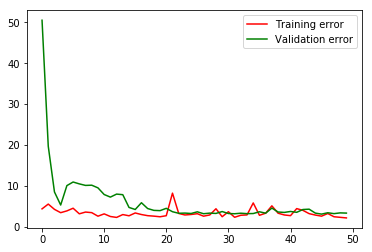

In [150]:
num_steps = 5000

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

with tf.Session() as sess:
    
    sess.run(init)
    #saver.restore(sess, "./saved_models/keypoints_3_lay_cnn_" + str(counter))
    #saver.restore(sess, "./saved_models/keypoints_3_lay_cnn_3")
    train_losses = []
    cv_losses = []
    
    
    for iteration in range(num_steps+1):
        
        x_batch, keypoints_batch = next_batch(x_train, keypoints_train, 32)
        
        
        # Uncomment for BN
        _ , train_loss= sess.run([train, masked_loss], 
                             feed_dict={x: x_batch, keypoints_true: keypoints_batch,
                                        lr:0.01, training:True})
        
        if iteration%100 == 0:
            
            cv_loss = sess.run(masked_loss, feed_dict={x:x_cv,keypoints_true:keypoints_cv,
                                                       training:False})
            
            train_losses.append(np.sqrt(train_loss))
            cv_losses.append(np.sqrt(cv_loss))
                        
            # Showing output for tracking progress.
            print('=======================================')
            print('Currently on step {}'.format(iteration))
            print('Train MSE: ', train_losses[-1], '\n')
            print('CV MSE:', cv_losses[-1], '\n')
            
            ax.cla()
            ax.plot(train_losses[1:], 'r', label = 'Training error')
            ax.plot(cv_losses[1:], 'g', label = 'Validation error')
            ax.legend()
            display(fig)
            
            print('=======================================')
            print('train_losses = ', train_losses, '\n')
            print('cv_losses = ', cv_losses)
            
            clear_output(wait = True)
    
    # printing final results
    
    print('=======================================')
    print('Currently on step {}'.format(iteration))
    print('Train MSE: ', train_losses[-1], '\n')
    print('CV MSE:',  cv_losses[-1], '\n')

    ax.cla()
    ax.plot(train_losses[1:], 'r', label = 'Training error')
    ax.plot(cv_losses[1:], 'g', label = 'Validation error')
    ax.legend()
    
            
    print('=======================================')
    print('train_losses = ', train_losses, '\n')
    print('cv_losses = ', cv_losses)
            
    #saver.save(sess, "./saved_models/keypoints_cnn_" + str(counter) )
    #saver.save(sess, "./saved_models/keypoints_3_lay_cnn_1"  )
    #counter +=1
    #print(counter)

In [ ]:
tf.get_default_graph()

In [151]:
np.mean(cv_losses[-10:])

3.5462265

In [70]:
np.min(cv_losses)

128.66379

## Predictions for the cv set

In [ ]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./saved_models/keypoints_3_lay_cnn_" + str(counter))

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
        
    predictions = sess.run(keypoints_pred, feed_dict= {x:x_cv, drop_rate:0 })
    

In [ ]:
predictions.shape

In [ ]:
np.max(predictions)

In [ ]:
np.unravel_index( np.argmax(predictions), predictions.shape)

In [ ]:
predictions[73,29]

In [ ]:
x_cv.shape

In [ ]:
grid_size = 3
fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

selection = np.random.choice(range(len(x_cv)), size = grid_size**2, )

mean_x_points = [keypoints_mean[j] for j in range(0,30,2)]
mean_y_points = [keypoints_mean[j+1] for j in range(0,30,2)]

for i, ax in zip(selection, axes.flat):

    ax.axis('off')
    # Plotting the faces
    ax.imshow(x_cv[i].reshape((96,96)),cmap='gist_gray')

 # Obtaining keypoints positions. x and y coordinates are even and odd indices respectively. 
    x_points = [predictions[i][j] for j in range(0,30,2)]
    y_points = [predictions[i][j+1] for j in range(0,30,2)]
      
    #plotting predicted keypoints
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')    
  
 # Plotting true keypoints
    
    x_true = [keypoints_cv.iloc[i][j] for j in range(0,30,2)]
    y_true = [keypoints_cv.iloc[i][j+1] for j in range(0,30,2)]
    
    ax.plot(x_true, y_true, 'b*', markerfacecolor = 'none')    
    
 # Including mean keypoints
       
    #ax.plot(mean_x_points, mean_y_points, 'b+', markerfacecolor = 'none')  

## Predictions for the test set

In [ ]:
test_data = pd.read_csv('test.csv')
test_data.shape

In [ ]:
test_data.head()

In [ ]:
test_images = test_data['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))

test_images = np.vstack([test_images.iloc[i] for i in range(len(test_images))])

In [ ]:
saver = tf.train.Saver()

In [ ]:
with tf.Session() as sess:
    
    
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./saved_models/keypoints_3_lay_cnn_" + str(counter))
    #saver.restore(sess, "./saved_models/keypoints_3_lay_cnn_3" )

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
        
    predictions = sess.run(keypoints_pred, feed_dict= {x:test_images, drop_rate:0 })
    

In [ ]:
predictions.shape

In [ ]:
grid_size = 2
fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

#selection = np.random.choice(range(len(test_images)), size = grid_size**2 )
selection = [131, 159, 491, 525]
for i, ax in zip(selection, axes.flat):

    ax.axis('off')
    # Plotting the faces
    ax.imshow(test_images[i].reshape((96,96)),cmap='gist_gray')

 # Obtaining keypoints positions. x and y coordinates are even and odd indices respectively. 
    x_points = [predictions[i][j] for j in range(0,30,2)]
    y_points = [predictions[i][j+1] for j in range(0,30,2)]
      
    #plotting predicted keypoints
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')    

## Make a dataframe with predictions

In [ ]:
predicted_keypoints = pd.DataFrame(data = predictions, columns = keypoints.columns)

In [ ]:
predicted_keypoints[(predicted_keypoints>96).any(1)]

In [ ]:
predicted_keypoints.to_csv('full_test_predictions_002.csv')

## Loading the lookup table to make a submission file. 

In [ ]:
lookup_table = pd.read_csv('IdLookupTable.csv', header = 0, index_col = 'RowId')

In [ ]:
locations_list = []
for i in lookup_table.iterrows():
    position = predicted_keypoints.iloc[i[1]['ImageId']-1][i[1]['FeatureName']]
    locations_list.append(position)
len(locations_list)

In [ ]:
#empty dataframe for testing submission
Submission_df = pd.DataFrame(columns = ['Location'], index = lookup_table.index)

In [ ]:
Submission_df['Location'] = locations_list

In [ ]:
Submission_df.to_csv('submission_002.csv')